In [ ]:
import pandas as pd 
import csv
import numpy as np
import matplotlib.pyplot as plt 
import math
#from pandas_datareader import data
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
from statsmodels.graphics import gofplots
from statsmodels.regression import linear_model
from scipy import stats
import scipy.integrate
import scipy.special
# from arch.unitroot import PhillipsPerron
import yfinance as yf
from sklearn.linear_model import LinearRegression

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import time

In [ ]:
from google.colab import files
files.upload() # run this command to manually upload TechTickers.csv 

Saving TechTickers.csv to TechTickers.csv


{'TechTickers.csv': b'AAPL\nMSFT\nTSM\nINTC\nCSCO\nORCL\nSAP\nADBE\nCRM\nNVDA\nACN\nASML\nAVGO\nTXN\nIBM\nQCOM\nFIS\nINTU\nMU\nVMW\nAMAT\nAMD\nNOW\nADI\nLRCX\nINFY\nADSK\nWDAY\nNXPI\nCTSH\nTEL\nAPH\nHPQ\nCAJ\nERIC\nMSI\nKLAC\nMCHP\nFLT\nSPLK\nSTM\nVRSN\nGLW\nPANW\nGIB\nANSS\nSNPS\nWDC\nSWKS\nCDNS\nFTNT\nGRMN\nMRVL\nCHKP\nSTX\nSSNC\nAKAM\nNTAP\nBR\nIT\nLDOS\nZBRA\nTDY\nEPAM\nOTEX\nTYL\nUI\nTER\nFICO\nJKHY\nASX\n'}

In [ ]:
#read list if tickers from a csv file and print them out

tickers_file = 'TechTickers.csv'
tickers = []

remove_list=['EPAM','ASML','IBM','STM']

f = open(tickers_file,"r",encoding='utf-8-sig')
for line in csv.reader(f):
    if str(line[0]) not in remove_list:
        tickers.append(str(line[0]))
f.close
print(tickers)
print(len(tickers))
tickers_str = tickers[0]
for s in tickers[1:]: tickers_str=tickers_str+", "+s

['AAPL', 'MSFT', 'TSM', 'INTC', 'CSCO', 'ORCL', 'SAP', 'ADBE', 'CRM', 'NVDA', 'ACN', 'AVGO', 'TXN', 'QCOM', 'FIS', 'INTU', 'MU', 'VMW', 'AMAT', 'AMD', 'NOW', 'ADI', 'LRCX', 'INFY', 'ADSK', 'WDAY', 'NXPI', 'CTSH', 'TEL', 'APH', 'HPQ', 'CAJ', 'ERIC', 'MSI', 'KLAC', 'MCHP', 'FLT', 'SPLK', 'VRSN', 'GLW', 'PANW', 'GIB', 'ANSS', 'SNPS', 'WDC', 'SWKS', 'CDNS', 'FTNT', 'GRMN', 'MRVL', 'CHKP', 'STX', 'SSNC', 'AKAM', 'NTAP', 'BR', 'IT', 'LDOS', 'ZBRA', 'TDY', 'OTEX', 'TYL', 'UI', 'TER', 'FICO', 'JKHY', 'ASX']
67


In [ ]:
#downoad the prices and volumes for the previously read list of tickers for the first month
#of the earliest year in the proposed time period
#should take less than 1 min for google colab to download the data 
start_date = '2021-01-01'
end_date = '2021-12-31'
stock_data = yf.download(tickers_str, start_date, end_date)
price = stock_data['Adj Close'].values
#np.savetxt("StockPriceMATH584.csv",price,delimiter=',')

[*********************100%***********************]  67 of 67 completed


In [ ]:
def FormPairs(d):
    PI = []
    for i in range(d):
        for j in range(i+1,d):
            PI.append([i,j])
    return(PI)

In [ ]:
def my_c(P1,P2):
    dx = [np.diff(P1[:-1])]
    dx.append(np.diff(P2[:-1]))
    dx = np.array(dx).T
    dy = [np.diff(P1[1:])]
    dy.append(np.diff(P2[1:]))
    dy = np.array(dy).T
    reg_results = LinearRegression().fit(dx,dy)
    Phi = reg_results.coef_+np.identity(2)
    #res = [dy[i,:] - dx[i,:]@reg_results.coef_.T for i in range(len(dy[:,0]))]
    rho, v = np.linalg.eig(Phi.T)
    if (rho[0].imag==0): _c = [-v[1,0]/v[0,0],-v[1,1]/v[0,1]]
    else: _c = [-1,-1]
    return _c

In [ ]:
def TestPair(Pi,Pj,p_star,rho_star):
    #ar_order=1
    ar_order = 2
    n = np.min([len(Pi),len(Pj)])
    #if kf == 0:
    #c_array = [stats.linregress(Pj,Pi)[0]]
    c_array = my_c(Pi,Pj)
    my_pval = 1.0
    Z = list(Pi)
    c = 0
    meanZ = np.mean(Z)
    sigma = np.std(Z)
    for c_temp in c_array:
        if c_temp>0:
            Z_temp = Pi-c_temp*Pj
            meanZ_temp = np.mean(Z_temp)
            Z_temp = Z_temp-meanZ_temp
            my_DF = stattools.adfuller(Z_temp,ar_order,'c',None)
            #my_PP = PhillipsPerron(Z)
            coint_idx, phi, sigma_temp = 0, np.nan, np.std(Z_temp)
            #my_pval = np.max([my_DF[1],my_PP.pvalue])
            if my_DF[1]<my_pval: 
                my_pval = my_DF[1]
                Z = list(Z_temp)
                c = c_temp
                meanZ = meanZ_temp
                sigma = sigma_temp
    #my_pval = my_PP.pvalue
    coint_idx = 0
    if my_pval < p_star:
        phi_vec, sigma0 = linear_model.yule_walker(Z,order=ar_order)
        #phi = phi_vec[0] + phi_vec[1]
        phi=0
        for i in range(ar_order): phi=phi+phi_vec[i]
        #if ar_order>1: phi+=phi_vec[1]
        if phi < rho_star: coint_idx = 1
    return coint_idx, c, meanZ, sigma

# Test basic pairs trading strategy

In [ ]:
# Input parameters
d = len(tickers)
C_bar = 1e6

N = 60
bt_len = 190
T_bar = 20
p_star = 0.01
rho_star = 0.7
thres_coef = 1.0
close_coef = 0.0
stoploss_coef = 4.0
l = 0.000 # T-cost

win=0
lose=0
t_held = []
t_lost = []
spread_size = []
spread_size_win = []
spread_size_lose = []
use_log=0#set to zero if using prices, set to one if using log-prices
if use_log==1: prices=np.log(price)
else: prices = np.array(price)

# Preparation
t_start = N-1
t_end = t_start + bt_len
pairs = FormPairs(d)
n_pairs = len(pairs)

pair_status = np.zeros([n_pairs,7]) 
### each row of pair_status: [+1/0/-1(long, closed or short), date of open, sigma_tilde,
### shares in Pi, shares in Pj, c, mean of Pi-cPj] 

# Start backtesting
open_count, close_count = 0, 0
start = time.time()
shares = np.zeros(d)
xi = []
abs_PnL, abs_PnL_process = 0, []

#analyze the long and short sides separately
abs_PnL_process_long = []
abs_PnL_long = 0
rel_PnL_process_long = []
rel_PnL_long = 1
cap_long = []
abs_PnL_process_short = []
abs_PnL_short = 0
cap_short = []
shares_long_old = np.zeros(d)
shares_short_old = np.zeros(d)

for t in range(t_start,t_end):
    print('t=', t)
    start_t = time.time()
    price_cali = prices[(t-N+1):(t+1)]
    delta_shares = np.zeros(d)
    for k in range(n_pairs):
        p = pairs[k]
        Pi_today, Pj_today = prices[t,p[0]], prices[t,p[1]]        
        if (pair_status[k,0] == 0):
            # Find co-integrated pairs
            Pi_cali, Pj_cali = price_cali[:,p[0]], price_cali[:,p[1]]
            coint_indx, c, meanZ, sigma = TestPair(Pi_cali,Pj_cali,p_star,rho_star)        
            if coint_indx == 1: # Open the pair
                ## Find lambda2
                lam1 = Pi_today-c*Pj_today-meanZ
                if (np.abs(lam1)>= sigma*thres_coef) & (np.abs(lam1)<= sigma*stoploss_coef):
                    ls = -np.sign(lam1) # ls=1 means to long the pair
                    pair_status[k,0]=ls
                    pair_status[k,1]=t
                    pair_status[k,2]=sigma
                    inv_coef = np.max([1.0,np.abs(c*Pj_today/Pi_today)])
                    pair_status[k,3]=C_bar*ls/(Pi_today*inv_coef) 
                    pair_status[k,4]=-c*C_bar*ls/(Pi_today*inv_coef)
                    pair_status[k,5]=c 
                    pair_status[k,6]=meanZ 
                    delta_shares[p[0]] += pair_status[k,3]
                    delta_shares[p[1]] += pair_status[k,4]
                    spread_size.append(sigma/(Pi_today*inv_coef))
        else:
            close_idx = 0            
            ## Check stopping cirteria
            if t-pair_status[k,1] > T_bar: 
                close_idx = 1
                lose+=1
                t_lost.append(t-pair_status[k,1])
                inv_coef = np.max([1.0,np.abs(pair_status[k,5]*Pj_today/Pi_today)])
                spread_size_lose.append(pair_status[k,2]/(Pi_today*inv_coef))
            else:
                sigma, c, meanZ = pair_status[k,2], pair_status[k,5], pair_status[k,6]
                if np.abs(Pi_today-c*Pj_today-meanZ) > stoploss_coef*sigma: 
                    close_idx = 1
                    lose+=1
                    t_lost.append(t-pair_status[k,1])
                    inv_coef = np.max([1.0,np.abs(pair_status[k,5]*Pj_today/Pi_today)])
                    spread_size_lose.append(pair_status[k,2]/(Pi_today*inv_coef))
                else:
                    ls = pair_status[k,0]
                    if ls*(Pi_today-c*Pj_today-meanZ) > sigma*close_coef: 
                        close_idx = 1
                        win+=1
                        t_held.append(t-pair_status[k,1])
                        inv_coef = np.max([1.0,np.abs(pair_status[k,5]*Pj_today/Pi_today)])
                        spread_size_win.append(pair_status[k,2]/(Pi_today*inv_coef))
            if close_idx == 1: # Close the pair
                delta_shares[p[0]] -= pair_status[k,3]
                delta_shares[p[1]] -= pair_status[k,4]
                pair_status[k,:] = np.zeros(7)
    end_t = time.time()
    print('There are', np.sum(pair_status[:,0]!=0), 'opened pairs.')
    print('This step takes', end_t-start_t, 'seconds')
    ## Compute PnL
    abs_PnL = abs_PnL + (prices[t]-prices[t-1])@shares - prices[t]@np.abs(delta_shares)*l
    abs_PnL_process.append(abs_PnL)
    print('PnL so far is ', abs_PnL)
    #if (t == t_start) | (shares@price[t-1]==0): 
    #  rel_PnL = rel_PnL * 1 
    #else:
    #  rel_PnL = rel_PnL * ( 1 + (abs_PnL_process[-1]-abs_PnL_process[-2])/(shares@price[t-1]) )      
    #rel_PnL_process.append(rel_PnL)
    ## Update position
    shares_long = np.zeros(d)
    shares_short = np.zeros(d)
    shares_long=np.where(shares > 0, shares, 0)
    shares_short=np.where(shares < 0, shares, 0)
    abs_PnL_long += (price[t]-price[t-1])@shares_long - price[t-1]@np.abs(shares_long-shares_long_old)*l
    abs_PnL_process_long.append(abs_PnL_long)
    cap_long.append(price[t-1]@shares_long)
    abs_PnL_short += (price[t]-price[t-1])@shares_short - price[t-1]@np.abs(shares_short-shares_short_old)*l
    abs_PnL_process_short.append(abs_PnL_short)
    cap_short.append(price[t-1]@shares_short)
    
    shares_long_old = np.array([shares_long[i] for i in range(len(shares_long))])
    shares_short_old = np.array([shares_short[i] for i in range(len(shares_short))])
    shares += delta_shares
    xi.append(shares)
                    
        
end = time.time()

print('\n')
print('It takes', end-start, 'seconds to finish a backtesting of', bt_len, 'days.')

temp = np.array(abs_PnL_process[1:])-np.array(abs_PnL_process[:-1])
abs_PnL_SharpeRatio = np.mean(temp) / np.std(temp)
#temp = ( np.array(rel_PnL_process[1:])-np.array(rel_PnL_process[:-1]) ) / np.array(rel_PnL_process[1:])
#rel_PnL_SharpeRatio = np.mean(temp) / np.std(temp)

t= 59
There are 0 opened pairs.
This step takes 8.542053699493408 seconds
PnL so far is  0.0
t= 60
There are 0 opened pairs.
This step takes 7.727365493774414 seconds
PnL so far is  0.0
t= 61
There are 1 opened pairs.
This step takes 6.601881265640259 seconds
PnL so far is  0.0
t= 62
There are 3 opened pairs.
This step takes 12.22120976448059 seconds
PnL so far is  -1977.6015094440718
t= 63
There are 5 opened pairs.
This step takes 7.003960371017456 seconds
PnL so far is  53520.72939713235
t= 64
There are 6 opened pairs.
This step takes 4.645435571670532 seconds
PnL so far is  73860.05201391104
t= 65
There are 6 opened pairs.
This step takes 5.427306175231934 seconds
PnL so far is  17693.745785714185
t= 66
There are 6 opened pairs.
This step takes 4.558157682418823 seconds
PnL so far is  19758.257151301026
t= 67
There are 6 opened pairs.
This step takes 4.546706199645996 seconds
PnL so far is  -32959.01310067218
t= 68
There are 6 opened pairs.
This step takes 5.3765480518341064 seconds

192
193


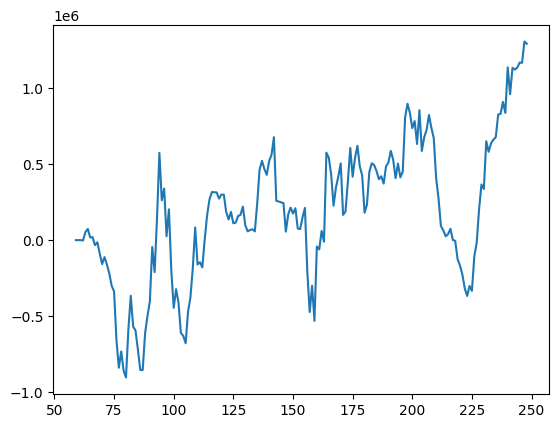

Sharpe ratio of the absolute returns is 0.6920296463342971


In [ ]:
print(win)
print(lose)
#print(len(abs_PnL_process))
#print(t_end-t_start)
plt.plot(range(t_start,t_end), abs_PnL_process)
plt.show()
print('Sharpe ratio of the absolute returns is', abs_PnL_SharpeRatio*(250**0.5))

(array([52., 34., 30., 23., 16., 23.,  3.,  5.,  2.,  4.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <BarContainer object of 10 artists>)

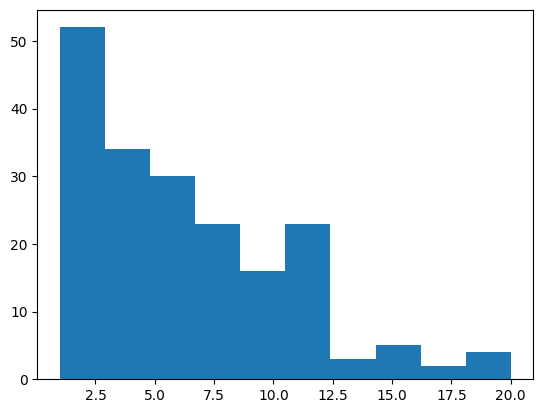

In [ ]:
plt.hist(t_held)#holding times for winning pairs

(array([24., 26., 34., 12.,  9., 13., 11.,  7.,  2., 55.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

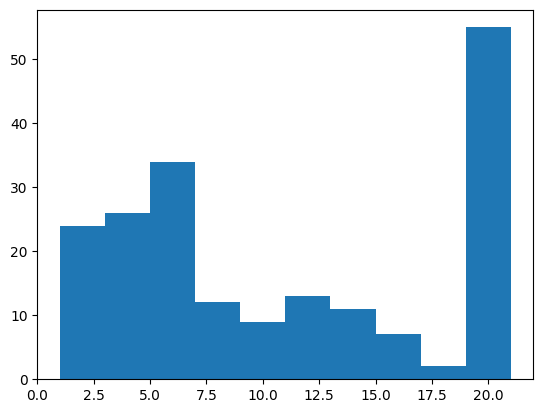

In [ ]:
plt.hist(t_lost)#holding times for losing pairs

(array([ 61., 128.,  97.,  53.,  43.,  14.,   3.,   0.,   1.,   1.]),
 array([0.00737502, 0.01263074, 0.01788646, 0.02314218, 0.0283979 ,
        0.03365362, 0.03890934, 0.04416506, 0.04942078, 0.0546765 ,
        0.05993221]),
 <BarContainer object of 10 artists>)

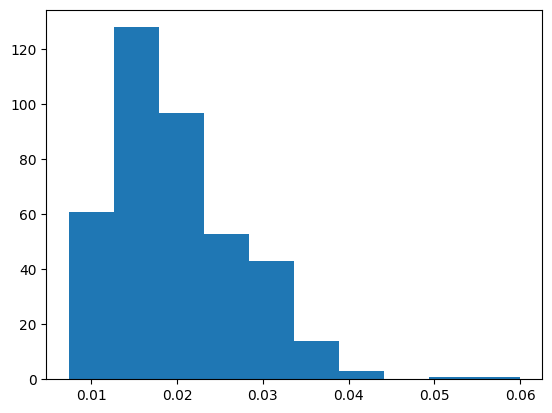

In [ ]:
plt.hist(spread_size)

(array([22., 31., 46., 36., 20., 18.,  7.,  9.,  1.,  2.]),
 array([0.00733171, 0.01083227, 0.01433283, 0.0178334 , 0.02133396,
        0.02483452, 0.02833508, 0.03183564, 0.0353362 , 0.03883676,
        0.04233732]),
 <BarContainer object of 10 artists>)

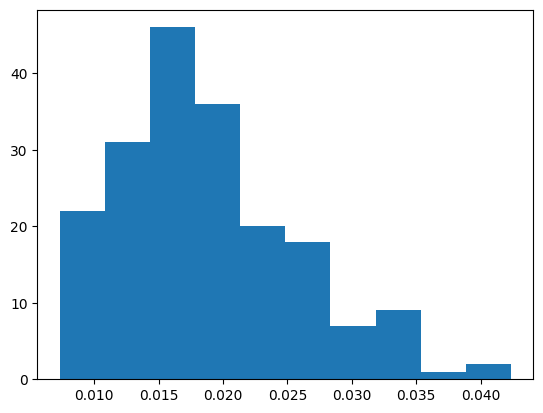

In [ ]:
plt.hist(spread_size_win)

(array([33., 46., 48., 31., 22., 11.,  0.,  0.,  0.,  2.]),
 array([0.00756068, 0.01258318, 0.01760567, 0.02262817, 0.02765067,
        0.03267316, 0.03769566, 0.04271816, 0.04774065, 0.05276315,
        0.05778565]),
 <BarContainer object of 10 artists>)

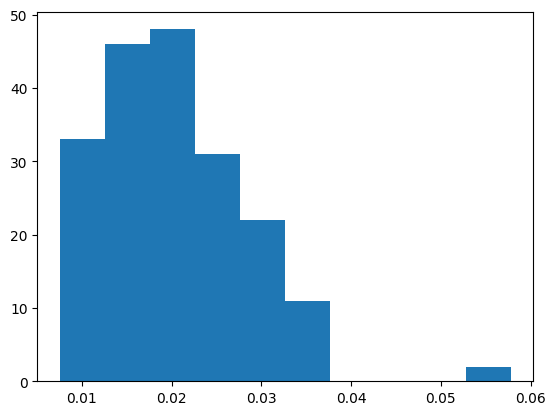

In [ ]:
plt.hist(spread_size_lose)

In [ ]:
#temp = np.array(rel_PnL_process_long[1:])/np.array(rel_PnL_process_long[:-1])-1
#rel_SharpeRatio_long = np.mean(temp) / np.std(temp)
temp = np.array(abs_PnL_process_long[1:])-np.array(abs_PnL_process_long[:-1])
SharpeRatio_long = np.mean(temp) / np.std(temp)
temp = np.array(abs_PnL_process_short[1:])-np.array(abs_PnL_process_short[:-1])
SharpeRatio_short = np.mean(temp) / np.std(temp)

In [ ]:
#plt.plot(range(t_start,t_end), rel_PnL_process_long)
#plt.show()
#print('The sharp ratio associated with relative long PnL is', rel_SharpeRatio_long*(250**0.5))

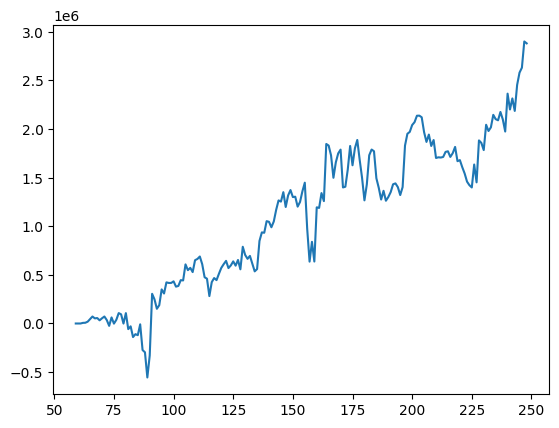

Sharpe ratio of the absolute returns of long positions is 1.613946881043244


In [ ]:
plt.plot(range(t_start,t_end), abs_PnL_process_long)
plt.show()
print('Sharpe ratio of the absolute returns of long positions is', SharpeRatio_long*(250**0.5))

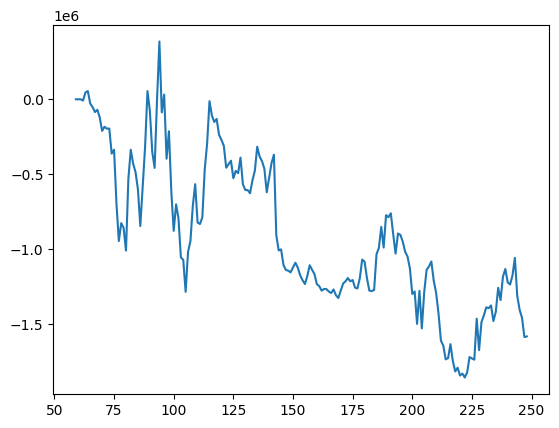

Sharpe ratio of the absolute returns of short positions is -0.8901575776347502


In [ ]:
plt.plot(range(t_start,t_end), abs_PnL_process_short)
plt.show()
print('Sharpe ratio of the absolute returns of short positions is', SharpeRatio_short*(250**0.5))

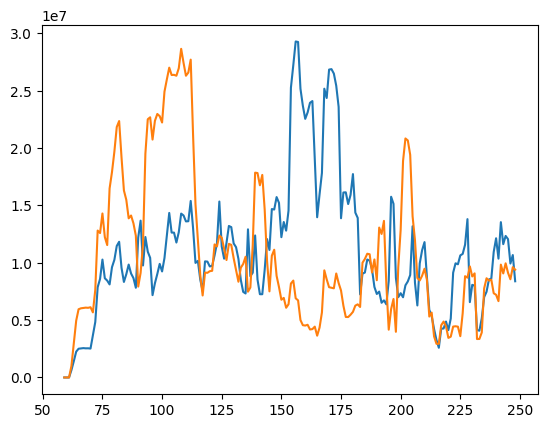

In [ ]:
plt.plot(range(t_start,t_end), np.abs(cap_long))
plt.plot(range(t_start,t_end), np.abs(cap_short))
plt.show()

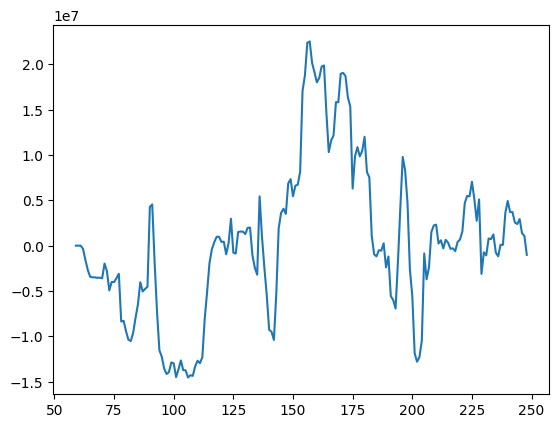

In [ ]:
plt.plot(range(t_start,t_end), np.array(cap_long)+np.array(cap_short))
plt.show()

# Market neutral startegy (hedging with index)

In [ ]:
#downoad SP500
ticker_name = '^GSPC'
#ticker_name = 'AAPL'
stock_data = yf.download(ticker_name, start_date, end_date)
index = stock_data['Adj Close'].values
#plt.plot(index)
#print(index[10][0])

[*********************100%***********************]  1 of 1 completed


In [ ]:
#compute the index PnL
PnL_process_ind = []
PnL_ind = 0
#index_n=list(index)
#print(np.shape(index_n))
for t in range(0,len(cap_long)):
    PnL_ind = PnL_ind-(index[t+t_start]/index[t+t_start-1]-1)*(cap_long[t]+cap_short[t])
    #print(index[t+t_start+1]/index[t+t_start]-1)
    PnL_process_ind.append(PnL_ind)
temp = np.array(PnL_process_ind[1:])-np.array(PnL_process_ind[:-1])
SharpeRatio_ind = np.mean(temp) / np.std(temp)

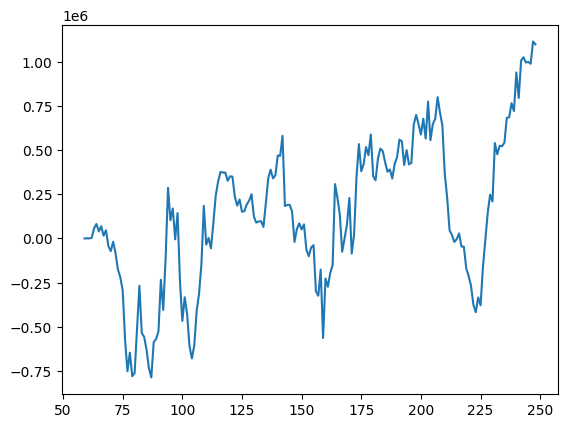

Sharpe ratio of the absolute returns of the market-neutral strategy is 0.6616971204431853


In [ ]:
#compute the PnL of hedged strategy
PnL_tot = np.array(abs_PnL_process) + np.array(PnL_process_ind)
temp = np.array(PnL_tot[1:])-np.array(PnL_tot[:-1])
SharpeRatio_tot = np.mean(temp) / np.std(temp)
plt.plot(range(t_start,t_end), PnL_tot)
plt.show()
print('Sharpe ratio of the absolute returns of the market-neutral strategy is', SharpeRatio_tot*(250**0.5))